## Dependências

In [67]:
!pip install seaborn
!pip install geopandas
!pip install folium
!pip install geopandas contextily matplotlib seaborn pyproj
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 15.0 MB/s eta 0:00:0000:0100:01


## Testes e Validações

In [42]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

con.close()
con = duckdb.connect('dev.duckdb', read_only=True)

query = "SELECT * FROM main.stg_base_bruta_acidentes WHERE numero_boletim = '2021-009100344-001'"
df = con.execute(query).fetchdf()

# Configura o pandas para mostrar todas as colunas ao imprimir o DataFrame
pd.set_option('display.max_columns', None)

# Agora imprime as 100 primeiras linhas com todas as colunas visíveis
print(df.head(100))


       numero_boletim data_hora_boletim     data_inclusao tipo_acidente  \
0  2021-009100344-001  21/02/2021 17:02  21/02/2021 18:17        H08002   

                                  desc_tipo_acidente  cod_tempo  \
0  CHOQUE MECANICO COM VITIMA                    ...          4   

        desc_tempo  cod_pavimento        pavimento  cod_regional  \
0  NUBLADO                      1  ASFALTO                    23   

     desc_regional   origem_boletim local_sinalizado  velocidade_permitida  \
0  NORTE            POLICIA MILITAR              NÃO                    60   

   coordenada_x  coordenada_y hora_informada indicador_fatalidade  valor_ups  \
0     613674.04    7805466.31            SIM                  SIM          0   

   descricao_ups data_alteracao_smsa  valor_ups_antiga descricao_ups_antiga  
0  NÃO INFORMADO          00/00/0000                 0        NÃO INFORMADO  


In [43]:
con.close()

## Visualizações e Análises

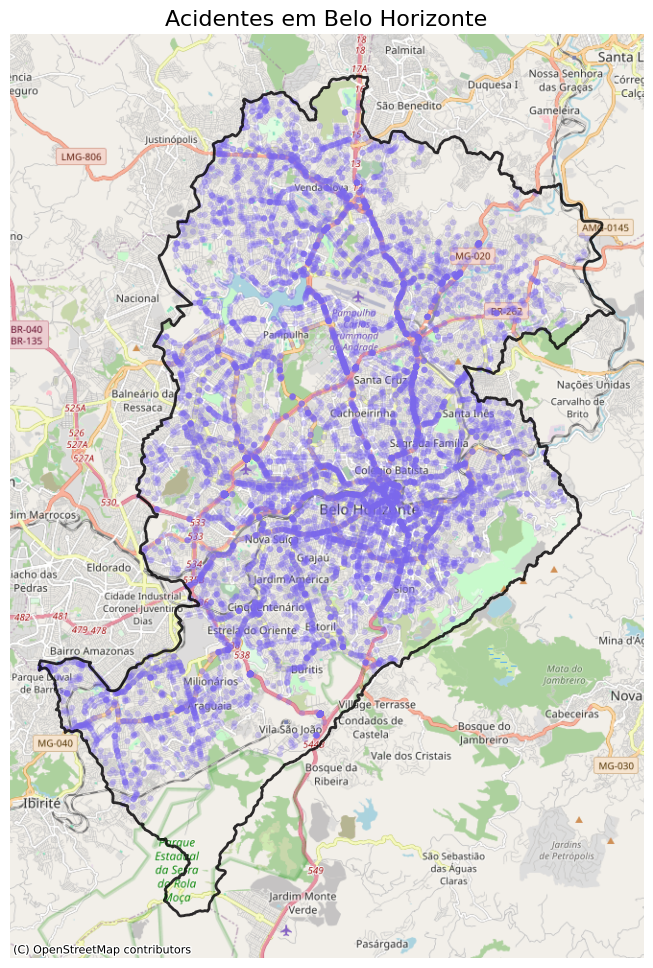

In [70]:
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer

# --- Consulta ao DuckDB ---
con = duckdb.connect('dev.duckdb', read_only=True)
query = """
SELECT longitude, latitude
FROM analise_geografica_acidentes
WHERE longitude IS NOT NULL AND latitude IS NOT NULL
"""
df = con.execute(query).fetchdf()
con.close()

# --- Converte UTM para Lat/Lon ---
transformer = Transformer.from_crs("EPSG:31983", "EPSG:4326", always_xy=True)
df[['lon', 'lat']] = df.apply(lambda row: pd.Series(transformer.transform(row['longitude'], row['latitude'])), axis=1)

# --- Carrega shape de Belo Horizonte ---
bh_shape = gpd.read_file('limite_municipio.json')

# --- Cria GeoDataFrame dos acidentes ---
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

# Ajusta CRS para serem iguais
if bh_shape.crs != gdf.crs:
    bh_shape = bh_shape.to_crs(gdf.crs)

# Clipa pontos dentro de BH
gdf_clip = gpd.sjoin(gdf, bh_shape, predicate='within')

# Converte para Web Mercator para plotar com contextily
gdf_clip = gdf_clip.to_crs(epsg=3857)
bh_shape = bh_shape.to_crs(epsg=3857)

# --- Plota ---
fig, ax = plt.subplots(figsize=(12, 12))

# Define limites baseados no limite de BH, com margem
xmin, ymin, xmax, ymax = bh_shape.total_bounds
margin_x = (xmax - xmin) * 0.05
margin_y = (ymax - ymin) * 0.05
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

# Adiciona mapa base (contextily) primeiro
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Plota pontos no mapa
ax.scatter(
    gdf_clip.geometry.x, gdf_clip.geometry.y,
    s=20,  # tamanho do ponto
    color='mediumslateblue',  # cor suave (pode trocar)
    alpha=0.3,  # transparência
    edgecolors='none'
)

# Plota limite de BH por cima
bh_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=2, alpha=0.8)

ax.set_axis_off()
plt.title('Acidentes em Belo Horizonte', fontsize=16)
plt.show()
